In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-dataset/diabetes.csv


In [2]:
# Problem : Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi modeli geliştirilmesi
# istenmektedir. Modeli geliştirmeden önce gerekli olan veri analizi ve özellik mühendisliği adımlarını gerçekleştirmeniz beklenmektedir.

# Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır.
# ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları
# üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal bağımsız değişkenden oluşmaktadır.
# Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

# Pregnancies: Hamilelik sayısı
# Glucose: Glikoz
# BloodPressure: Kan basıncı (Diastolic(Küçük Tansiyon))
# SkinThickness: Cilt Kalınlığı
# Insulin: İnsülin.
# BMI: Beden kitle indeksi.
# DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
# Age: Yaş (yıl)
# Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)


# GÖREV 1: KEŞİFCİ VERİ ANALİZİ
           # Adım 1: Genel resmi inceleyiniz.
           # Adım 2: Numerik ve kategorik değişkenleri yakalayınız.
           # Adım 3:  Numerik ve kategorik değişkenlerin analizini yapınız.
           # Adım 4: Hedef değişken analizi yapınız. (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre numerik değişkenlerin ortalaması)
           # Adım 5: Korelasyon analizi yapınız.

# GÖREV 2: FEATURE ENGINEERING
           # Adım 1: Aykırı gözlem analizi yapınız.
           # Adım 2: Eksik gözlem analizi yapınız.
           # Adım 3:  Eksik ve aykırı değerler için gerekli işlemleri yapınız. Veri setinde eksik gözlem bulunmamakta ama Glikoz, Insulin vb.
           # değişkenlerde 0 değeri içeren gözlem birimleri eksik değeri ifade ediyor olabilir. Örneğin; bir kişinin glikoz veya insulin değeri
           # 0 olamayacaktır. Bu durumu dikkate alarak sıfır değerlerini ilgili değerlerde NaN olarak atama yapıp sonrasında eksik değerlere
           # işlemleri uygulayabilirsiniz.
           # Adım 4: Yeni değişkenler oluşturunuz.
           # Adım 5:  Encoding işlemlerini gerçekleştiriniz.
           # Adım 6: Numerik değişkenler için standartlaştırma yapınız.
           # Adım 7: Model oluşturunuz.



In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda  x: '%.3f' % x)
pd.set_option('display.width', 500)

In [5]:
df = pd.read_csv("/kaggle/input/diabetes-dataset/diabetes.csv")

# **Keşifçi Veri Analizi**

In [6]:
# Adım 1: Genel resmi inceledim

def check_df(dataframe, head=5):
    print("############################################")
    print(dataframe.shape)
    print("############################################")
    print(dataframe.dtypes)
    print("############################################")
    print(dataframe.head(head))
    print("############################################")
    print(dataframe.tail(head))
    print("############################################")
    print(dataframe.isnull().sum())
    print("############################################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_df(df)

############################################
(768, 9)
############################################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
############################################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 28.100         

In [7]:
# Adım 2: Numerik ve kategorik değişkenleri yakaladım

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi
    """
    
    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if ((dataframe[col].dtypes != 'O') and
                                                     (dataframe[col].nunique() < cat_th))]
    cat_but_car = [col for col in dataframe.columns if ((dataframe[col].dtypes == 'O') and
                                                       (dataframe[col].nunique() > car_th))]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [8]:
# Adım 3:  kategorik ve Numerik değişkenlerin analizini yaptım

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe[col_name])}))
    
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
        
for col in cat_cols:
    cat_summary(df, col)

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896


count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
100%     17.000
max      17.000
Name: Pregnancies, dtype: float64


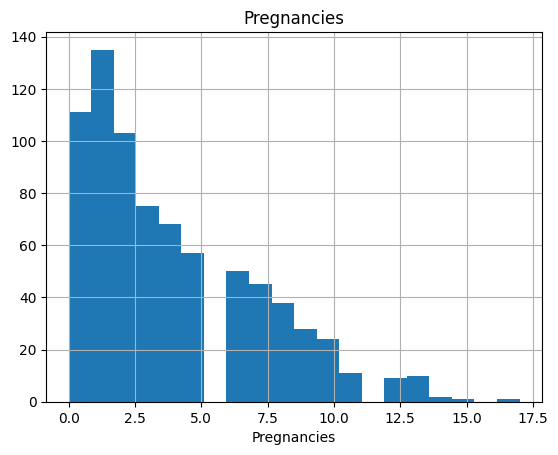

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
100%    199.000
max     199.000
Name: Glucose, dtype: float64


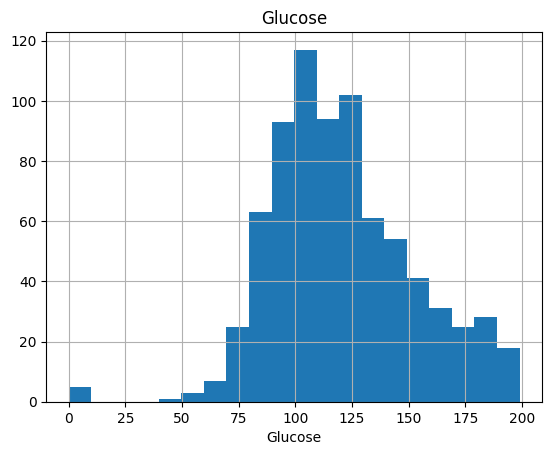

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
100%    122.000
max     122.000
Name: BloodPressure, dtype: float64


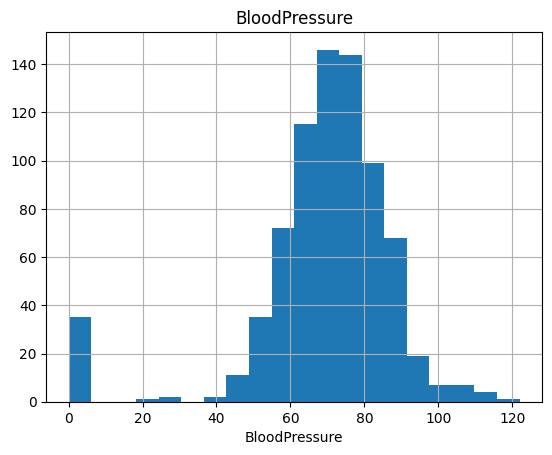

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
100%     99.000
max      99.000
Name: SkinThickness, dtype: float64


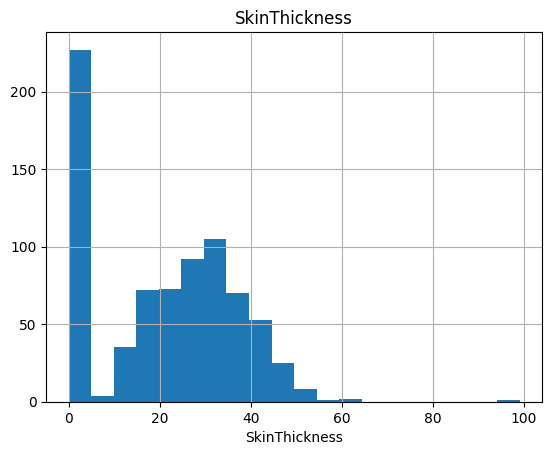

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
100%    846.000
max     846.000
Name: Insulin, dtype: float64


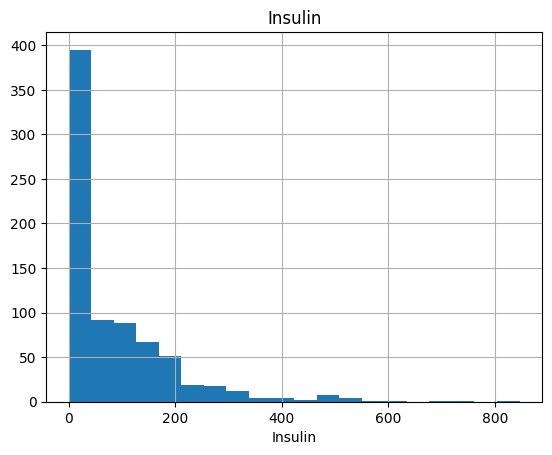

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
100%     67.100
max      67.100
Name: BMI, dtype: float64


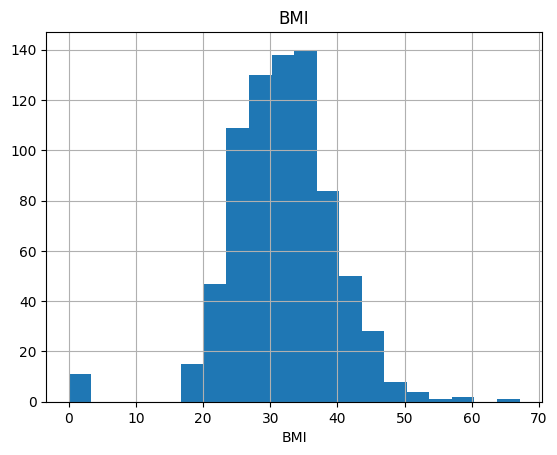

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
100%      2.420
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


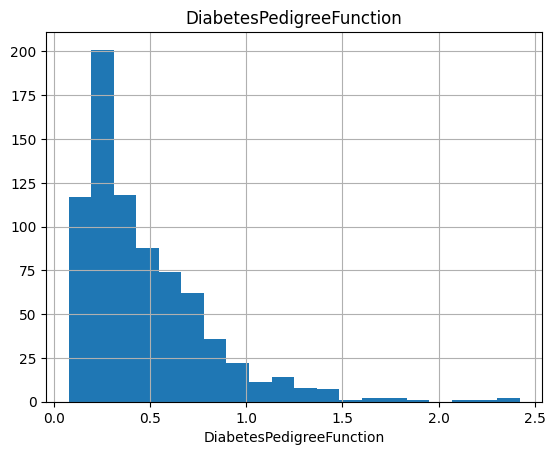

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
100%     81.000
max      81.000
Name: Age, dtype: float64


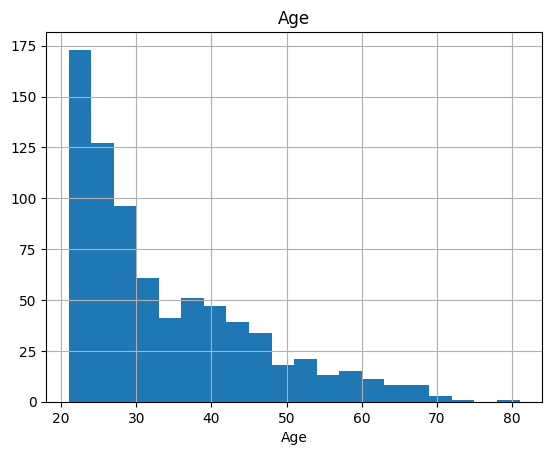

In [9]:
def num_summary(dataframe, num_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1]
    print(dataframe[num_col].describe(quantiles).T)
    
    if plot:
        dataframe[num_col].hist(bins=20)
        plt.xlabel(num_col)
        plt.title(num_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, True)

In [10]:
# Adım 4: Hedef değişken analizi yaptım

def target_analysis_num(dataframe, target, num_col):
    print(dataframe.groupby(target).agg({num_col: "mean"}), end="\n\n\n\n")
    
for col in num_cols:
    target_analysis_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866



         Glucose
Outcome         
0        109.980
1        141.257



         BloodPressure
Outcome               
0               68.184
1               70.825



         SkinThickness
Outcome               
0               19.664
1               22.164



         Insulin
Outcome         
0         68.792
1        100.336



           BMI
Outcome       
0       30.304
1       35.143



         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550



           Age
Outcome       
0       31.190
1       37.067





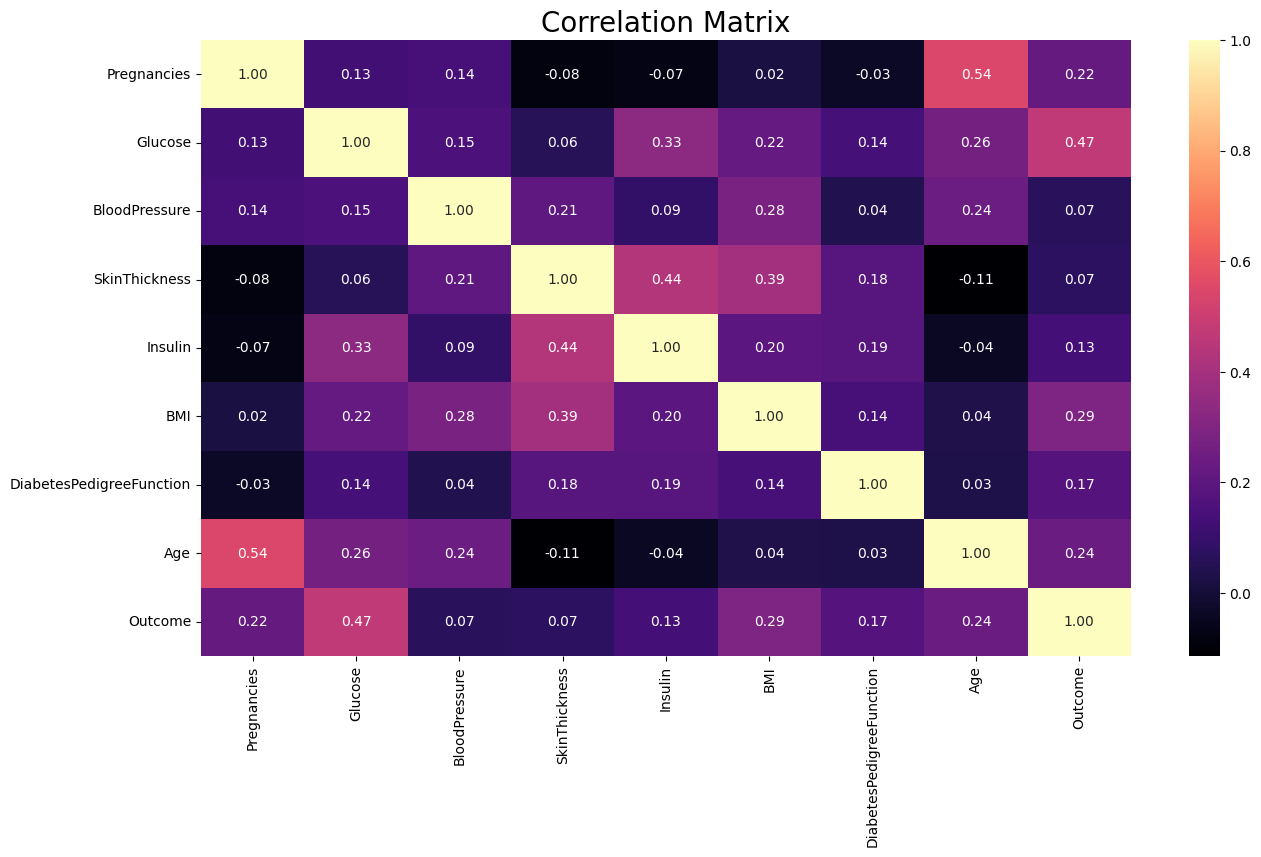

In [11]:
# Adım 5: Korelasyon analizi yaptım.

df.corr()

f, ax = plt.subplots(figsize=[15, 8])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()



# **Feature Engineering**

In [12]:
#Eksik değer analizi
#Bir insanda Pregnancies ve Outcome dışında 0 olamaz. 0 olanlara NaN atadım.

zero_columns = [col for col in df.columns if ((df[col].min() == 0) and (col not in ["Pregnancies", "Outcome"]))]
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [13]:
for col in zero_columns:
    df[col] = np.where(df[col]==0, np.nan, df[col])

In [14]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [15]:
#Eksik değerlerin sayısı ve oranı

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n\n")
    if na_name:
        return na_columns
    
na_columns = missing_values_table(df, True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650



In [16]:
#Eksik değerlerin bağımlı değişeken ile ilişkisinin inceledim.

def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                           "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")
missing_vs_target(df, "Outcome", na_columns)
    

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [17]:
#eksik değerlerin doldurdum

for col in na_columns:
    df.loc[df[col].isnull(), col] = df[col].median()

df.isnull().sum()
    

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [18]:
#Aykırı değer analizi yaptım

def outlier_threshold(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile = quartile3 - quartile1
    low_limit = quartile1 - 1.5 * interquantile
    up_limit = quartile3 + 1.5 * interquantile
    
    return low_limit, up_limit

In [19]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_threshold(dataframe, col_name)
    if dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None):
        return True
    else:
        return False
    
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [20]:
#Aykırı değerleri sınır değerleri ile doldurdum.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_threshold(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(df, col)


/tmp/ipykernel_18/1132568537.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-34.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


In [21]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


In [22]:
## Özellik Çıkarımlarını yaptım

#yaşa göre
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[df["Age"] >= 50, "NEW_AGE_CAT"] = "senior"


In [23]:
#BMI
df["NEW_BMI"] = pd.cut(x=df["BMI"], bins=[0, 18.5, 25, 30, 100], 
                       labels=["Underweight", "Healthy", "Overweight", "Obese"])

In [24]:
#Glukozun kanda normal değerde olması normoglisemi,
#Normalden düşük çıkması hipoglisemi
#Normalden yüksek çıkmasına ise hiperglisemi olarak adlandırılır.

df["NEW_GLUCOSE_CAT"] = pd.cut(x=df["Glucose"], bins=[0, 70, 140, 200], 
                       labels=["Hipoglisemi", "Normal", "Hiperglisemi"])


In [25]:
# BMI VE AGE birlikte
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_CAT"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_CAT"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_CAT"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_CAT"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_CAT"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_CAT"] = "overweightsenior"
df.loc[(df["BMI"] >= 30) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_CAT"] = "obesemature"
df.loc[(df["BMI"] >= 30) & (df["Age"] >= 50), "NEW_AGE_BMI_CAT"] = "obesesenior"


In [26]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE_CAT,NEW_AGE_BMI_CAT
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,senior,Obese,Hiperglisemi,obesesenior
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,mature,Overweight,Normal,overweightmature
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,mature,Healthy,Hiperglisemi,healthymature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,mature,Overweight,Normal,overweightmature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,mature,Obese,Normal,obesemature


In [27]:
#Glikoz ve Age birlikte 
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_CAT"] = "hipoglisemimature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_CAT"] = "hipoglisemisenior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 140)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_CAT"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 140)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_CAT"] = "normalsenior"
df.loc[(df["Glucose"] >= 140) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_CAT"] = "hiperglisemimature"
df.loc[(df["Glucose"] >= 140) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_CAT"] = "hiperglisemisenior"

In [28]:
#Insulin değeri ile kategorik değişken

def set_insulin(dataframe, col_name="Insulin"):
    if 30 <= dataframe[col_name] <=120:
        return "Normal"
    else:
        return "Anormal"
    
df["NEW_INSULIN_CAT"] = df.apply(set_insulin, axis=1)

In [29]:
df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]
df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]


In [30]:
df.columns = [col.upper() for col in df.columns]
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE_CAT,NEW_AGE_BMI_CAT,NEW_AGE_GLUCOSE_CAT,NEW_INSULIN_CAT,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,senior,Obese,Hiperglisemi,obesesenior,hiperglisemisenior,Anormal,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,mature,Overweight,Normal,overweightmature,normalmature,Anormal,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,mature,Healthy,Hiperglisemi,healthymature,hiperglisemimature,Anormal,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,mature,Overweight,Normal,overweightmature,normalmature,Normal,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,mature,Obese,Normal,obesemature,normalmature,Anormal,23016.000,0.000


In [31]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [32]:
#Label encoding yaptım

def label_encoding(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes =="O" and df[col].nunique() ==2]
binary_cols

['NEW_AGE_CAT', 'NEW_INSULIN_CAT']

In [33]:
for col in binary_cols:
    df = label_encoding(df, col)
    
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE_CAT,NEW_AGE_BMI_CAT,NEW_AGE_GLUCOSE_CAT,NEW_INSULIN_CAT,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,1,Obese,Hiperglisemi,obesesenior,hiperglisemisenior,0,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,0,Overweight,Normal,overweightmature,normalmature,0,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,0,Healthy,Hiperglisemi,healthymature,hiperglisemimature,0,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,0,Overweight,Normal,overweightmature,normalmature,1,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,0,Obese,Normal,obesemature,normalmature,0,23016.000,0.000


In [34]:
#One-Hot Encoding yaptım

cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
def one_hot_encoder(dataframe, cat_col, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=cat_col, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols)
df.head()

df = df.replace({True: 1, False: 0})

/tmp/ipykernel_18/3111212156.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


In [35]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_CAT,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_CAT_healthysenior,NEW_AGE_BMI_CAT_obesemature,NEW_AGE_BMI_CAT_obesesenior,NEW_AGE_BMI_CAT_overweightmature,NEW_AGE_BMI_CAT_overweightsenior,NEW_AGE_BMI_CAT_underweightmature,NEW_AGE_GLUCOSE_CAT_hiperglisemisenior,NEW_AGE_GLUCOSE_CAT_hipoglisemimature,NEW_AGE_GLUCOSE_CAT_hipoglisemisenior,NEW_AGE_GLUCOSE_CAT_normalmature,NEW_AGE_GLUCOSE_CAT_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_CAT_Normal,NEW_GLUCOSE_CAT_Hiperglisemi
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,1,0,18500.000,888.000,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,0,0,10625.000,85.000,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,0,0,22875.000,1464.000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,0,1,8366.000,89.000,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,0,0,23016.000,0.000,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0


In [36]:
#Standartlaştırma yaptım

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_CAT,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_CAT_healthysenior,NEW_AGE_BMI_CAT_obesemature,NEW_AGE_BMI_CAT_obesesenior,NEW_AGE_BMI_CAT_overweightmature,NEW_AGE_BMI_CAT_overweightsenior,NEW_AGE_BMI_CAT_underweightmature,NEW_AGE_GLUCOSE_CAT_hiperglisemisenior,NEW_AGE_GLUCOSE_CAT_hipoglisemimature,NEW_AGE_GLUCOSE_CAT_hipoglisemisenior,NEW_AGE_GLUCOSE_CAT_normalmature,NEW_AGE_GLUCOSE_CAT_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_CAT_Normal,NEW_GLUCOSE_CAT_Hiperglisemi
0,0.640,0.866,-0.032,0.680,-0.183,0.167,0.468,1.426,1,1,0,0.024,0.882,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1
1,-0.845,-1.205,-0.528,-0.011,-0.183,-0.852,-0.365,-0.191,0,0,0,-0.503,-0.858,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0
2,1.234,2.017,-0.694,-0.011,-0.183,-1.333,0.604,-0.106,1,0,0,0.317,2.129,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,-0.845,-1.074,-0.528,-0.702,-0.553,-0.634,-0.921,-1.042,0,0,1,-0.654,-0.849,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0
4,-1.142,0.504,-2.679,0.680,0.331,1.549,5.485,-0.020,1,0,0,0.326,-1.042,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0


In [37]:
# Modelleme

y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.20, random_state=17)


In [38]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]                                          
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

# **Random Forest Model**

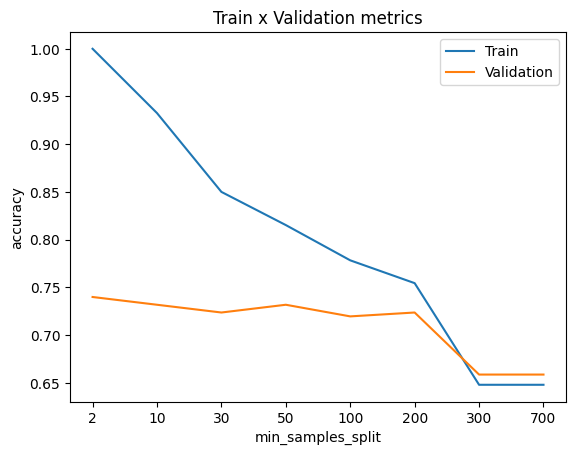

In [39]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = 46).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

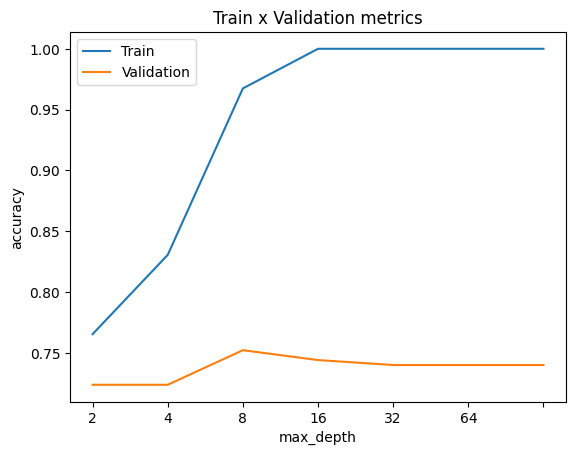

In [40]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = 46).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

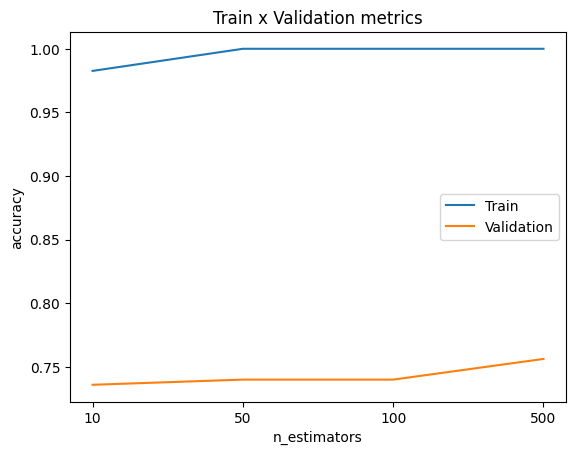

In [41]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = 46).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

In [42]:

rf_model = RandomForestClassifier(n_estimators = 500,
                                  max_depth = 8,
                                  min_samples_split = 30,
                                  random_state=46).fit(X_train, y_train)
y_pred_1 = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred_1, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred_1,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred_1,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred_1,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred_1,y_test), 2)}")


Accuracy: 0.85
Recall: 0.81
Precision: 0.77
F1: 0.79
Auc: 0.84


    Value                                 Feature
1   0.170                                 GLUCOSE
10  0.141                     NEW_GLUCOSE*INSULIN
11  0.111                 NEW_GLUCOSE*PREGNANCIES
7   0.085                                     AGE
27  0.080            NEW_GLUCOSE_CAT_Hiperglisemi
5   0.073                                     BMI
6   0.064                DIABETESPEDIGREEFUNCTION
26  0.046                  NEW_GLUCOSE_CAT_Normal
0   0.043                             PREGNANCIES
21  0.039        NEW_AGE_GLUCOSE_CAT_normalmature
4   0.035                                 INSULIN
3   0.029                           SKINTHICKNESS
2   0.028                           BLOODPRESSURE
25  0.014                           NEW_BMI_Obese
9   0.012                         NEW_INSULIN_CAT
23  0.008                         NEW_BMI_Healthy
13  0.005             NEW_AGE_BMI_CAT_obesemature
16  0.003        NEW_AGE_BMI_CAT_overweightsenior
14  0.003             NEW_AGE_BMI_CAT_obesesenior


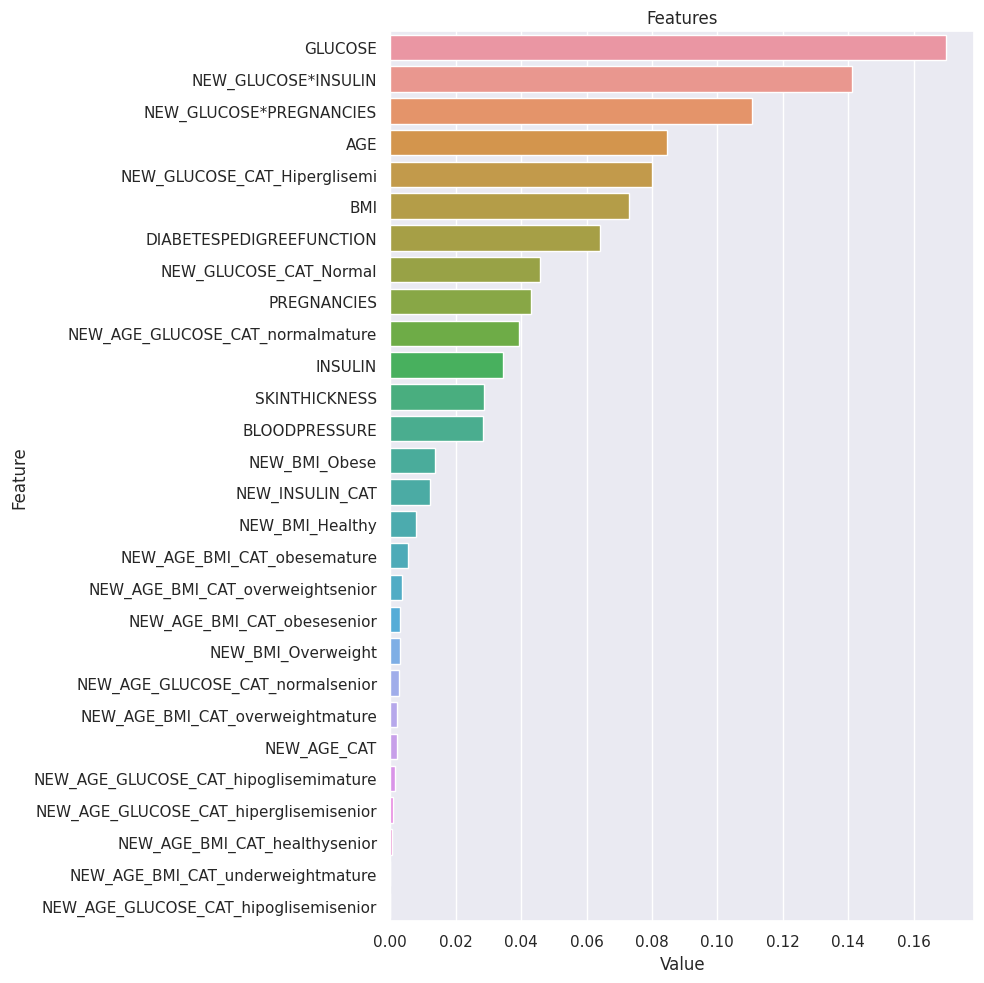

In [43]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)


# **Decision Tree Model**

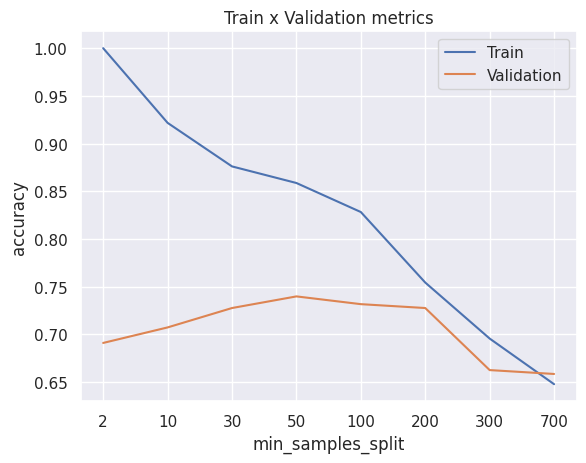

In [44]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = 46).fit(X_train,y_train) 
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

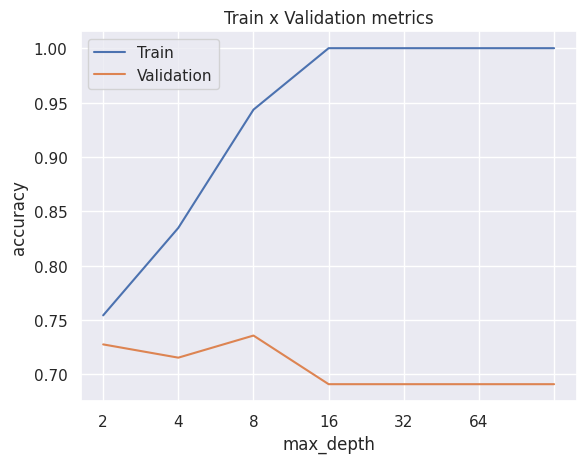

In [45]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = 46).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) 
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

In [46]:
dt_model = DecisionTreeClassifier(min_samples_split = 50,
                                             max_depth = 8,
                                             random_state = 46).fit(X_train,y_train)
y_pred_2 = dt_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred_2, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred_2,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred_2,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred_2,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred_2,y_test), 2)}")

Accuracy: 0.77
Recall: 0.682
Precision: 0.68
F1: 0.68
Auc: 0.75


    Value                                 Feature
10  0.420                     NEW_GLUCOSE*INSULIN
1   0.184                                 GLUCOSE
5   0.172                                     BMI
7   0.091                                     AGE
11  0.067                 NEW_GLUCOSE*PREGNANCIES
6   0.038                DIABETESPEDIGREEFUNCTION
16  0.016        NEW_AGE_BMI_CAT_overweightsenior
2   0.013                           BLOODPRESSURE
0   0.000                             PREGNANCIES
22  0.000        NEW_AGE_GLUCOSE_CAT_normalsenior
20  0.000   NEW_AGE_GLUCOSE_CAT_hipoglisemisenior
21  0.000        NEW_AGE_GLUCOSE_CAT_normalmature
23  0.000                         NEW_BMI_Healthy
18  0.000  NEW_AGE_GLUCOSE_CAT_hiperglisemisenior
24  0.000                      NEW_BMI_Overweight
25  0.000                           NEW_BMI_Obese
26  0.000                  NEW_GLUCOSE_CAT_Normal
19  0.000   NEW_AGE_GLUCOSE_CAT_hipoglisemimature
14  0.000             NEW_AGE_BMI_CAT_obesesenior


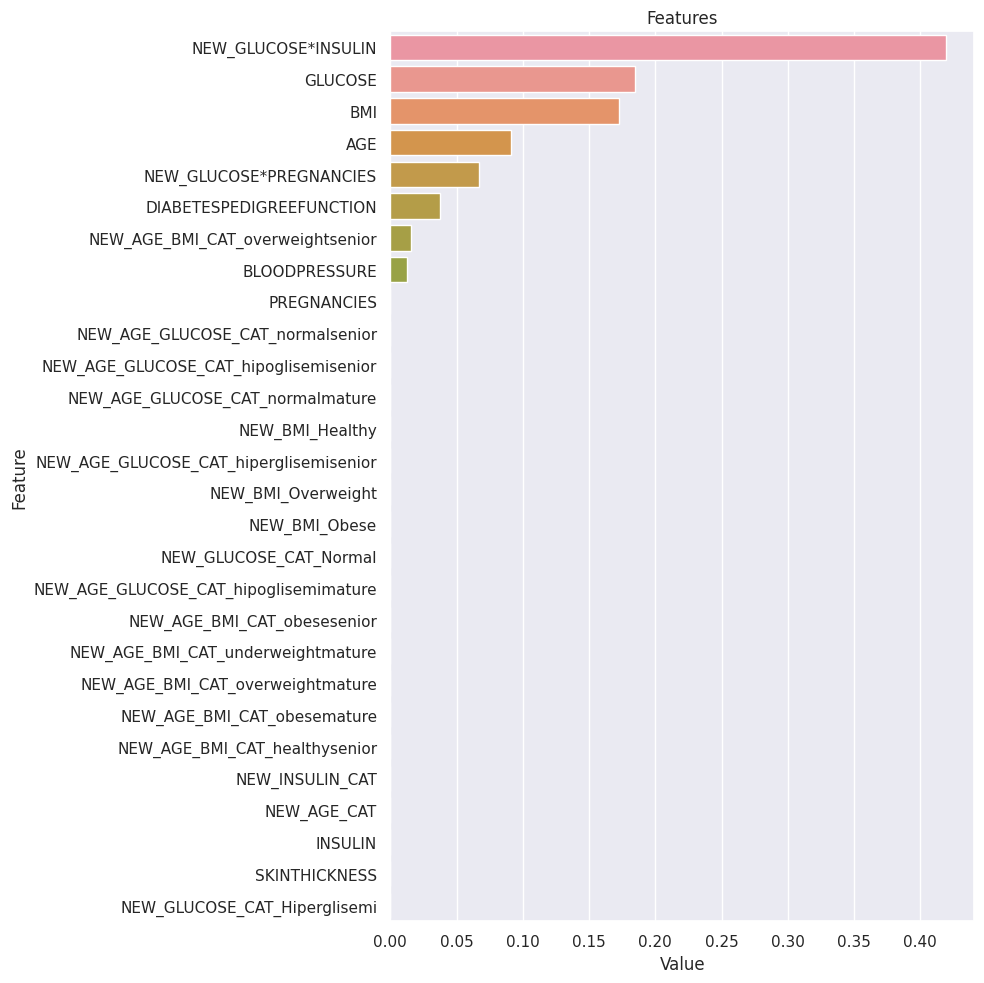

In [47]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(dt_model, X)


# **Logistic Regression Model**

In [48]:
lg_model = LogisticRegression()
lg_model.fit(X_train, y_train)

y_pred_3 = lg_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred_3, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred_3,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred_3,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred_3,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred_3,y_test), 2)}")


Accuracy: 0.84
Recall: 0.833
Precision: 0.68
F1: 0.75
Auc: 0.84


# **XGBoost Model**

In [49]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_4 = xgb_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred_4, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred_4,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred_4,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred_4,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred_4,y_test), 2)}")

Accuracy: 0.84
Recall: 0.773
Precision: 0.77
F1: 0.77
Auc: 0.82
